### Model Comparison

### Date: Jun 01, 2025

### Author: Hincal Topcuoglu, Ph.D.

Hincal Comment:

In this notebook, we learn more about model comparison. We will also explore methods of cross validation and additional plotting techniques for model comparison. We will also introduce the Xgboost model as additional model type.

We start, as always, with our libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import chi2_contingency

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

We work with the titantic data and prepare it as we have done previously.

In [2]:
titanic = pd.read_csv('titanic.csv')

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

Hincal Comment:

As we know the properties of titanic dataset from the clustering_pca notebook, I directly make feature engineering

In [3]:
# Drop a Cabin column
titanic = titanic.drop('Cabin', axis=1)

# Fill nulls with median
titanic['Age_imp'] = titanic['Age'].fillna(titanic['Age'].median())
titanic = titanic.drop('Age', axis=1)

## drop these 2 rows
titanic = titanic.dropna()

# Hincal Comment:
# We dont need here "Name", "Ticket" columns, they are needless, so I drop them too.
titanic = titanic.drop(['Name', 'Ticket'], axis=1)

# One-hot encode 'Sex' and 'Embarked' columns
titanic = pd.get_dummies(titanic, columns=['Sex', 'Embarked'], drop_first=True)

# Extract or create numeric features (e.g., FamilySize = SibSp + Parch + 1).
# Create FamilySize feature
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1

# Fare columns has more std than its mean I will standardize it.
# I didnt touch SibSp and Parch variables becasuse their meaning is different and have already used in creating new column

scaler = StandardScaler()

# scaling Fare
titanic['Fare_scaled'] = scaler.fit_transform(titanic[['Fare']])

## Scale Age_Imp also
titanic['Age_imp_scaled'] = scaler.fit_transform(titanic[['Age_imp']])

titanic.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age_imp,Sex_male,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Age_imp_scaled
0,1,0,3,1,0,7.2500,22.0,True,False,True,2,-0.500240,-0.563674
1,2,1,1,1,0,71.2833,38.0,False,False,False,2,0.788947,0.669217
2,3,1,3,0,0,7.9250,26.0,False,False,True,1,-0.486650,-0.255451
3,4,1,1,1,0,53.1000,35.0,False,False,True,2,0.422861,0.438050
4,5,0,3,0,0,8.0500,35.0,True,False,True,1,-0.484133,0.438050


---

Hincal Comment:
    
Workflow Summary

1-) Data Preparation:

Use the specified columns.

Perform binning on continuous variables (Fare, Age_imp, Fare_scaled, Age_imp_scaled, FamilySize) based on Weight of Evidence (WoE) or similar method.

2-) Correlation Analysis:

Calculate Cramér’s V correlation between binned categorical variables and the target (Survived).

3-)Model Training:

Train and evaluate the following classifiers:

Decision Tree Classifier

XGBoost Classifier

Random Forest Classifier

Naive Bayes Classifier

4-) Model Comparison:

Compare models using classification metrics (accuracy, precision, recall, F1, ROC AUC).

Visualize comparison with graphs (e.g., bar plots, ROC curves).

Hincal Comment:

I will create a unique dataset for the purpose of comparing ML algorithms with same measures. 

So I start with converting continous variables to categoric ones using "Weight of Evidence" Method 

In [4]:
# Function to calculate WoE and IV for a single feature
# Reference: https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets/notebook

def calculate_woe_iv(df, feature, target):
    lst = []
    for val in df[feature].unique():
        total = df[df[feature] == val].shape[0]
        good = df[(df[feature] == val) & (df[target] == 0)].shape[0]
        bad = df[(df[feature] == val) & (df[target] == 1)].shape[0]
        lst.append({'Value': val, 'All': total, 'Good': good, 'Bad': bad})
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    return dset, iv

# Convert categorical variables to category dtype
titanic['Survived'] = titanic['Survived'].astype('category')

# Binning continuous variables into quantiles first (4 bins) for WoE calculation
cont_vars = ['Fare', 'Age_imp', 'Fare_scaled', 'Age_imp_scaled', 'FamilySize']

# Create binned columns
for var in cont_vars:
    titanic[var + '_bin'] = pd.qcut(titanic[var], q=4, duplicates='drop')

# Calculate WoE for each binned variable
woe_dict = {}
iv_dict = {}
for var in cont_vars:
    binned_var = var + '_bin'
    woe_df, iv = calculate_woe_iv(titanic, binned_var, 'Survived')
    woe_dict[binned_var] = woe_df[['Value', 'WoE']]
    iv_dict[binned_var] = iv

woe_dict, iv_dict

({'Fare_bin':              Value       WoE
  0  (-0.001, 7.896]  0.924043
  1  (31.0, 512.329] -0.790740
  2  (7.896, 14.454]  0.351195
  3   (14.454, 31.0] -0.298483,
  'Age_imp_bin':            Value       WoE
  0  (0.419, 22.0] -0.173771
  1   (35.0, 80.0]  0.024238
  2   (22.0, 28.0]  0.223751
  3   (28.0, 35.0] -0.225957,
  'Fare_scaled_bin':                Value       WoE
  0   (-0.647, -0.487]  0.924043
  1   (-0.0221, 9.669] -0.790740
  2   (-0.487, -0.355]  0.351195
  3  (-0.355, -0.0221] -0.298483,
  'Age_imp_scaled_bin':                            Value       WoE
  0  (-2.2279999999999998, -0.564] -0.173771
  1                 (0.438, 3.906]  0.024238
  2               (-0.564, -0.101]  0.223751
  3                (-0.101, 0.438] -0.225957,
  'FamilySize_bin':           Value       WoE
  0  (0.999, 2.0]  0.099705
  1   (2.0, 11.0] -0.344234},
 {'Fare_bin': np.float64(0.39554933059821956),
  'Age_imp_bin': np.float64(0.032893477329726487),
  'Fare_scaled_bin': np.float64(0.39

In [5]:
# pretty view

woe_dict = {
    'Fare_bin': pd.DataFrame({
        'Value': ['(-0.001, 7.896]', '(7.896, 14.454]', '(14.454, 31.0]', '(31.0, 512.329]'],
        'WoE': [0.924043, 0.351195, -0.298483, -0.790740]
    }),
    'Age_imp_bin': pd.DataFrame({
        'Value': ['(0.419, 22.0]', '(22.0, 28.0]', '(28.0, 35.0]', '(35.0, 80.0]'],
        'WoE': [-0.173771, 0.223751, -0.225957, 0.024238]
    }),
    'Fare_scaled_bin': pd.DataFrame({
        'Value': ['(-0.647, -0.487]', '(-0.487, -0.355]', '(-0.355, -0.0221]', '(-0.0221, 9.669]'],
        'WoE': [0.924043, 0.351195, -0.298483, -0.790740]
    }),
    'Age_imp_scaled_bin': pd.DataFrame({
        'Value': ['(-2.228, -0.564]', '(-0.564, -0.101]', '(-0.101, 0.438]', '(0.438, 3.906]'],
        'WoE': [-0.173771, 0.223751, -0.225957, 0.024238]
    }),
    'FamilySize_bin': pd.DataFrame({
        'Value': ['(0.999, 2.0]', '(2.0, 11.0]'],
        'WoE': [0.099705, -0.344234]
    })
}

iv_dict = {
    'Fare_bin': 0.39554933059821956,
    'Age_imp_bin': 0.032893477329726487,
    'Fare_scaled_bin': 0.39554933059821956,
    'Age_imp_scaled_bin': 0.032893477329726487,
    'FamilySize_bin': 0.034224140828024475
}

# Pretty print WoE tables
print("Weight of Evidence (WoE) Tables:\n")
for var, df in woe_dict.items():
    print(f"Variable: {var}")
    print(df.to_string(index=False))
    print("\n")

# Pretty print IV values
iv_df = pd.DataFrame(list(iv_dict.items()), columns=['Variable', 'Information Value (IV)'])
print("Information Value (IV) Summary:\n")
print(iv_df.to_string(index=False))

Weight of Evidence (WoE) Tables:

Variable: Fare_bin
          Value       WoE
(-0.001, 7.896]  0.924043
(7.896, 14.454]  0.351195
 (14.454, 31.0] -0.298483
(31.0, 512.329] -0.790740


Variable: Age_imp_bin
        Value       WoE
(0.419, 22.0] -0.173771
 (22.0, 28.0]  0.223751
 (28.0, 35.0] -0.225957
 (35.0, 80.0]  0.024238


Variable: Fare_scaled_bin
            Value       WoE
 (-0.647, -0.487]  0.924043
 (-0.487, -0.355]  0.351195
(-0.355, -0.0221] -0.298483
 (-0.0221, 9.669] -0.790740


Variable: Age_imp_scaled_bin
           Value       WoE
(-2.228, -0.564] -0.173771
(-0.564, -0.101]  0.223751
 (-0.101, 0.438] -0.225957
  (0.438, 3.906]  0.024238


Variable: FamilySize_bin
       Value       WoE
(0.999, 2.0]  0.099705
 (2.0, 11.0] -0.344234


Information Value (IV) Summary:

          Variable  Information Value (IV)
          Fare_bin                0.395549
       Age_imp_bin                0.032893
   Fare_scaled_bin                0.395549
Age_imp_scaled_bin                0.

Hincal Comment:

Fare_bin : very good distribution acroos the bins, decresing order of WoE

Age_imp_bin : may be we should make it 2 categories

Familiy_size_bin : ok, low IV, but nothing to do

In [6]:
titanic.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age_imp,Sex_male,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Age_imp_scaled,Fare_bin,Age_imp_bin,Fare_scaled_bin,Age_imp_scaled_bin,FamilySize_bin
0,1,0,3,1,0,7.2500,22.0,True,False,True,2,-0.500240,-0.563674,"(-0.001, 7.896]","(0.419, 22.0]","(-0.647, -0.487]","(-2.2279999999999998, -0.564]","(0.999, 2.0]"
1,2,1,1,1,0,71.2833,38.0,False,False,False,2,0.788947,0.669217,"(31.0, 512.329]","(35.0, 80.0]","(-0.0221, 9.669]","(0.438, 3.906]","(0.999, 2.0]"
2,3,1,3,0,0,7.9250,26.0,False,False,True,1,-0.486650,-0.255451,"(7.896, 14.454]","(22.0, 28.0]","(-0.487, -0.355]","(-0.564, -0.101]","(0.999, 2.0]"
3,4,1,1,1,0,53.1000,35.0,False,False,True,2,0.422861,0.438050,"(31.0, 512.329]","(28.0, 35.0]","(-0.0221, 9.669]","(-0.101, 0.438]","(0.999, 2.0]"
4,5,0,3,0,0,8.0500,35.0,True,False,True,1,-0.484133,0.438050,"(7.896, 14.454]","(28.0, 35.0]","(-0.487, -0.355]","(-0.101, 0.438]","(0.999, 2.0]"


In [7]:
## rename bins
def rename_bin_categories_intervals(df):
    for col in df.columns:
        if col.endswith('_bin') or col.endswith('_bin_combined'):
            # Get unique categories (Interval objects)
            unique_bins = df[col].cat.categories if hasattr(df[col], 'cat') else df[col].unique()
            # Create simple category names
            new_categories = [f'Bin_{i+1}' for i in range(len(unique_bins))]
            # Create mapping from old categories to new names
            mapping = dict(zip(unique_bins, new_categories))
            # Replace categories if categorical
            if hasattr(df[col], 'cat'):
                df[col] = df[col].cat.rename_categories(mapping)
            else:
                df[col] = df[col].map(mapping)
            print(f"Renamed categories in {col}: {new_categories}")
    return df

# Apply to your DataFrame
titanic = rename_bin_categories_intervals(titanic)

# Check results
for col in titanic.columns:
    if col.endswith('_bin') or col.endswith('_bin_combined'):
        print(f"\n{col} categories:")
        print(titanic[col].value_counts())

Renamed categories in Fare_bin: ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4']
Renamed categories in Age_imp_bin: ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4']
Renamed categories in Fare_scaled_bin: ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4']
Renamed categories in Age_imp_scaled_bin: ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4']
Renamed categories in FamilySize_bin: ['Bin_1', 'Bin_2']

Fare_bin categories:
Fare_bin
Bin_2    224
Bin_1    223
Bin_3    222
Bin_4    220
Name: count, dtype: int64

Age_imp_bin categories:
Age_imp_bin
Bin_2    308
Bin_1    231
Bin_4    215
Bin_3    135
Name: count, dtype: int64

Fare_scaled_bin categories:
Fare_scaled_bin
Bin_2    224
Bin_1    223
Bin_3    222
Bin_4    220
Name: count, dtype: int64

Age_imp_scaled_bin categories:
Age_imp_scaled_bin
Bin_2    308
Bin_1    231
Bin_4    215
Bin_3    135
Name: count, dtype: int64

FamilySize_bin categories:
FamilySize_bin
Bin_1    696
Bin_2    193
Name: count, dtype: int64


In [8]:
titanic.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age_imp,Sex_male,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Age_imp_scaled,Fare_bin,Age_imp_bin,Fare_scaled_bin,Age_imp_scaled_bin,FamilySize_bin
0,1,0,3,1,0,7.2500,22.0,True,False,True,2,-0.500240,-0.563674,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
1,2,1,1,1,0,71.2833,38.0,False,False,False,2,0.788947,0.669217,Bin_4,Bin_4,Bin_4,Bin_4,Bin_1
2,3,1,3,0,0,7.9250,26.0,False,False,True,1,-0.486650,-0.255451,Bin_2,Bin_2,Bin_2,Bin_2,Bin_1
3,4,1,1,1,0,53.1000,35.0,False,False,True,2,0.422861,0.438050,Bin_4,Bin_3,Bin_4,Bin_3,Bin_1
4,5,0,3,0,0,8.0500,35.0,True,False,True,1,-0.484133,0.438050,Bin_2,Bin_3,Bin_2,Bin_3,Bin_1


In [9]:
titanic.dtypes

PassengerId              int64
Survived              category
Pclass                   int64
SibSp                    int64
Parch                    int64
Fare                   float64
Age_imp                float64
Sex_male                  bool
Embarked_Q                bool
Embarked_S                bool
FamilySize               int64
Fare_scaled            float64
Age_imp_scaled         float64
Fare_bin              category
Age_imp_bin           category
Fare_scaled_bin       category
Age_imp_scaled_bin    category
FamilySize_bin        category
dtype: object

Hincal Comment:

Yes, we binned continous variables into categoric bins by WoE method
Since we will make a model comparison we will use only binned categoric variables. To get best subset of categoric predictors lets compute cramer's V Correlation

In [10]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Select only binned categorical variables and target
categorical_cols = [
    'Survived',
    "Sex_male", 
    "Embarked_Q", 
    "Embarked_S",
    'Fare_bin',
    'Age_imp_bin',
    'Fare_scaled_bin',
    'Age_imp_scaled_bin',
    'FamilySize_bin'
]

# Calculate Cramer's V matrix
cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_results.loc[col1, col2] = cramers_v(titanic[col1], titanic[col2])

cramers_results = cramers_results.astype(float)
cramers_results

,Survived,Sex_male,Embarked_Q,Embarked_S,Fare_bin,Age_imp_bin,Fare_scaled_bin,Age_imp_scaled_bin,FamilySize_bin
Survived,0.997616,0.538418,0.000000,0.145446,0.291698,0.065992,0.291698,0.065992,0.081471
Sex_male,0.538418,0.997528,0.062635,0.113992,0.234396,0.061920,0.234396,0.061920,0.184387
Embarked_Q,0.000000,0.062635,0.992883,0.493924,0.301715,0.189864,0.301715,0.189864,0.037897
Embarked_S,0.145446,0.113992,0.493924,0.997180,0.229311,0.137723,0.229311,0.137723,0.048756
Fare_bin,0.291698,0.234396,0.301715,0.229311,1.000000,0.140118,1.000000,0.140118,0.434549
Age_imp_bin,0.065992,0.061920,0.189864,0.137723,0.140118,1.000000,0.140118,1.000000,0.235783
Fare_scaled_bin,0.291698,0.234396,0.301715,0.229311,1.000000,0.140118,1.000000,0.140118,0.434549
Age_imp_scaled_bin,0.065992,0.061920,0.189864,0.137723,0.140118,1.000000,0.140118,1.000000,0.235783
FamilySize_bin,0.081471,0.184387,0.037897,0.048756,0.434549,0.235783,0.434549,0.235783,0.996687


Hincal Comment:

Sex_male (0.54), Embarked_S(0.14), Fare_bin(0.29), FamilySize_bin(0.08) and Age_imp_scaled_bin(0.06) is a good selection.

Lets just get subset of these variables and check their correlations between them and also target variable

In [11]:
## check selected variables' multicolinearity
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Selected variables including target
selected_vars = ['Survived', 'Sex_male', 'Embarked_S', 'Fare_bin', 'FamilySize_bin', 'Age_imp_bin']

# Calculate Cramer's V matrix
cramers_results = pd.DataFrame(index=selected_vars, columns=selected_vars)

for col1 in selected_vars:
    for col2 in selected_vars:
        cramers_results.loc[col1, col2] = cramers_v(titanic[col1], titanic[col2])

cramers_results = cramers_results.astype(float)
cramers_results

,Survived,Sex_male,Embarked_S,Fare_bin,FamilySize_bin,Age_imp_bin
Survived,0.997616,0.538418,0.145446,0.291698,0.081471,0.065992
Sex_male,0.538418,0.997528,0.113992,0.234396,0.184387,0.061920
Embarked_S,0.145446,0.113992,0.997180,0.229311,0.048756,0.137723
Fare_bin,0.291698,0.234396,0.229311,1.000000,0.434549,0.140118
FamilySize_bin,0.081471,0.184387,0.048756,0.434549,0.996687,0.235783
Age_imp_bin,0.065992,0.061920,0.137723,0.140118,0.235783,1.000000


Hincal Comment:

Except for "Fare_bin" with "FamilySize_bin" where the correlation between them 0.43, there is no significant multicolinearity seems

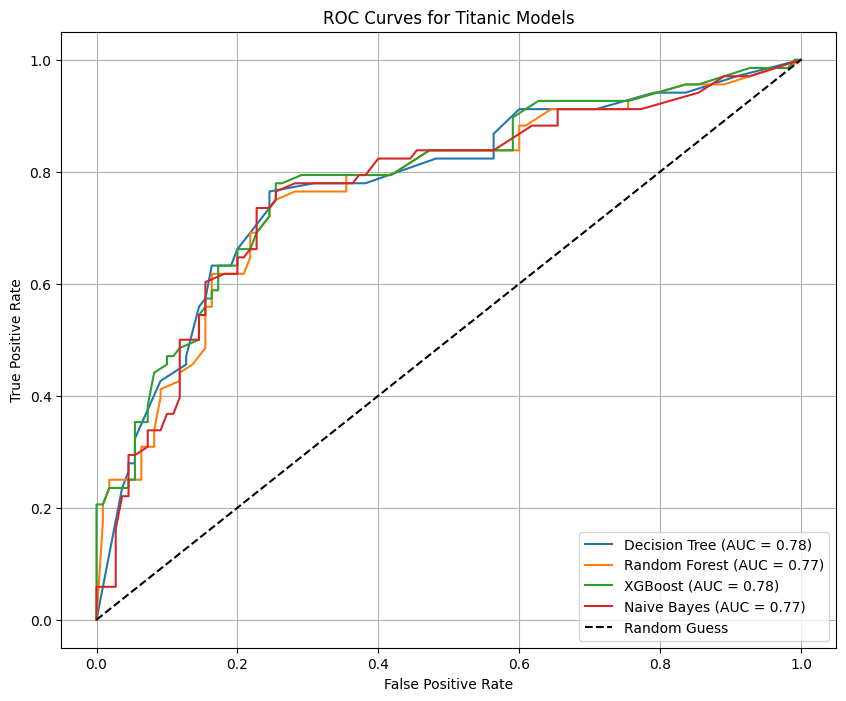

           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0        XGBoost  0.741573   0.689655  0.588235  0.634921  0.784626
1  Decision Tree  0.741573   0.696429  0.573529  0.629032  0.776471
2  Random Forest  0.747191   0.694915  0.602941  0.645669  0.769853
3    Naive Bayes  0.758427   0.666667  0.735294  0.699301  0.768717


In [13]:
# Make Model Comparison
# Selected features and target
selected_features = ['Sex_male', 'Embarked_S', 'Fare_bin', 'FamilySize_bin', 'Age_imp_bin']
target = 'Survived'

# Prepare X and y
X = titanic[selected_features].copy()
y = titanic[target].copy()

# One-hot encode categorical features (including binned variables)
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Naive Bayes': GaussianNB()
}

# Train, predict, and evaluate
results = []
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba, use decision_function or fallback
        y_proba = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Titanic Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display results table
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True))

In [14]:
def calculate_aic_bic(model, X, y):
    n = X.shape[0]
    k = X.shape[1] + 1  # number of features + intercept

    # Convert y to numeric if categorical
    if hasattr(y, 'cat'):
        y_numeric = y.cat.codes.values
    else:
        y_numeric = y.values if hasattr(y, 'values') else y

    # Get predicted probabilities for positive class
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X)[:, 1]
    else:
        probs = model.predict(X)
        probs = np.clip(probs, 1e-10, 1 - 1e-10)

    # Clip probs to avoid log(0)
    probs = np.clip(probs, 1e-10, 1 - 1e-10)

    # Calculate log-likelihood
    ll = np.sum(y_numeric * np.log(probs) + (1 - y_numeric) * np.log(1 - probs))

    # Calculate AIC and BIC
    aic = 2 * k - 2 * ll
    bic = np.log(n) * k - 2 * ll
    return aic, bic

# Assuming you have your models dictionary and train/test split as before
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict(X_test)
        y_proba = np.clip(y_proba, 1e-10, 1 - 1e-10)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    aic, bic = calculate_aic_bic(model, X_test, y_test)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'AIC': aic,
        'BIC': bic
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True))

           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0        XGBoost  0.741573   0.689655  0.588235  0.634921  0.784626   
1  Decision Tree  0.741573   0.696429  0.573529  0.629032  0.776471   
2  Random Forest  0.747191   0.694915  0.602941  0.645669  0.769853   
3    Naive Bayes  0.758427   0.666667  0.735294  0.699301  0.768717   

          AIC         BIC  
0  224.186188  256.004023  
1  465.205048  497.022883  
2  303.063923  334.881759  
3  256.432800  288.250636  


Hincal Comment:

Interpretation

-Naive Bayes has the highest accuracy, recall, and F1 score, indicating it balances well between identifying survivors and non-survivors.

-XGBoost has the highest ROC AUC and lowest AIC/BIC, suggesting it has the best overall discrimination and model fit.

-Random Forest performs well across metrics but has higher AIC/BIC than XGBoost.

-Decision Tree has the highest AIC/BIC, indicating a more complex model with potentially less generalization.

Recommendation

If your priority is overall discrimination and model fit, XGBoost is the best choice.

If you want a model with better recall and balanced F1, Naive Bayes is a strong candidate.

Random Forest is a good middle ground with solid performance.

Decision Tree is simplest but less optimal here.

---

Hincal Comment:

Let's do hyperparameter tuning and cross validation


Tuning Decision Tree...
Best params for Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}

Tuning Random Forest...
Best params for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5}

Tuning XGBoost...
Best params for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

Tuning Naive Bayes...

Cross-Validated Model Comparison:
           Model  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  \
0        XGBoost       0.775046      0.016813        0.731427       0.025839   
1  Random Forest       0.772799      0.018085        0.729799       0.019988   
2  Decision Tree       0.770571      0.023864        0.730922       0.044161   
3    Naive Bayes       0.759309      0.020221        0.681658       0.016056   

   Recall Mean  Recall Std   F1 Mean    F1 Std  ROC AUC Mean  ROC AUC Std  
0     0.652941    0.050602  0.688598  0.029840      0.828213     0.021894  
1  

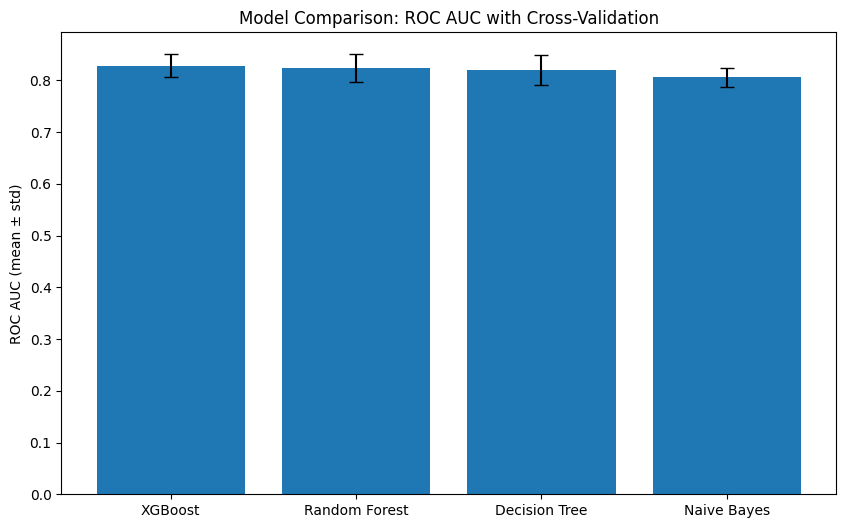

In [15]:
## hyperparameter tuning with RandomizedSearchCV and Cross Validation
selected_features = ['Sex_male', 'Embarked_S', 'Fare_bin', 'FamilySize_bin', 'Age_imp_scaled_bin']
target = 'Survived'

# Prepare X and y
X = titanic[selected_features].copy()
y = titanic[target].copy()

# One-hot encode categorical features (including binned variables)
X_encoded = pd.get_dummies(X, drop_first=True)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc', 'precision': 'precision', 'recall': 'recall'}

# Hyperparameter grids for each model
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    },
    'Naive Bayes': {
        # GaussianNB has no hyperparameters to tune here
    }
}

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Naive Bayes': GaussianNB()
}

# Store best estimators and results
best_estimators = {}
cv_results_summary = []

for name, model in models.items():
    print(f"\nTuning {name}...")
    if name != 'Naive Bayes':  # No hyperparameter tuning for Naive Bayes here
        param_grid = param_grids[name]
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=10,
            scoring='roc_auc',
            cv=cv,
            verbose=0,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_encoded, y)
        best_model = search.best_estimator_
        print(f"Best params for {name}: {search.best_params_}")
    else:
        # For Naive Bayes, just use the default model
        best_model = model
        best_model.fit(X_encoded, y)

    best_estimators[name] = best_model

    # Cross-validate best model on all metrics
    scores = {}
    for metric in scoring.keys():
        score = cross_val_score(best_model, X_encoded, y, cv=cv, scoring=scoring[metric], n_jobs=-1)
        scores[metric] = (score.mean(), score.std())

    cv_results_summary.append({
        'Model': name,
        'Accuracy Mean': scores['accuracy'][0],
        'Accuracy Std': scores['accuracy'][1],
        'Precision Mean': scores['precision'][0],
        'Precision Std': scores['precision'][1],
        'Recall Mean': scores['recall'][0],
        'Recall Std': scores['recall'][1],
        'F1 Mean': scores['f1'][0],
        'F1 Std': scores['f1'][1],
        'ROC AUC Mean': scores['roc_auc'][0],
        'ROC AUC Std': scores['roc_auc'][1]
    })

# Create DataFrame for results
results_df = pd.DataFrame(cv_results_summary)

# Display results sorted by ROC AUC mean
results_df_sorted = results_df.sort_values(by='ROC AUC Mean', ascending=False).reset_index(drop=True)
print("\nCross-Validated Model Comparison:")
print(results_df_sorted)

# Plot comparison of mean ROC AUC with error bars
plt.figure(figsize=(10, 6))
plt.bar(results_df_sorted['Model'], results_df_sorted['ROC AUC Mean'], yerr=results_df_sorted['ROC AUC Std'], capsize=5)
plt.ylabel('ROC AUC (mean ± std)')
plt.title('Model Comparison: ROC AUC with Cross-Validation')
plt.show()


Hincal Comment:

Interpretation

XGBoost leads in most metrics, especially ROC AUC and accuracy, with relatively low variability.

Random Forest and Decision Tree perform similarly, slightly behind XGBoost.

Naive Bayes has the highest recall but lower precision and accuracy, indicating it identifies more positives but with more false positives.

Variability (std) is reasonable across models, with Naive Bayes showing slightly higher recall variability.

---

Hincal Comment:

let's do GridSearch Hyperparameter tuning and cross-validation


Grid Search tuning for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Grid Search tuning for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}

Grid Search tuning for XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Grid Search tuning for Naive Bayes...

Grid Search Tuned Model Comparison:
           Model  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  \
0        XGBoost       0.775046      0.016813        0.731427       0.025839   
1  Random Forest       0.773922      0.017676        0.728393       0.024576   
2  Decision Tree       0.770571      0.023864        0.730922 

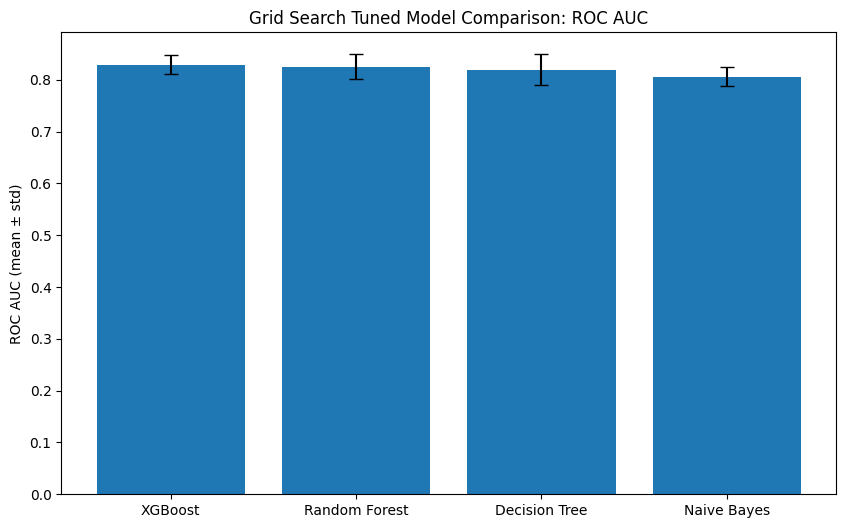

In [16]:
# Grid Search and cross-validation
selected_features = ['Sex_male', 'Embarked_S', 'Fare_bin', 'FamilySize_bin', 'Age_imp_scaled_bin']
target = 'Survived'

# Prepare X and y
X = titanic[selected_features].copy()
y = titanic[target].copy()

# One-hot encode categorical features (including binned variables)
X_encoded = pd.get_dummies(X, drop_first=True)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = 'roc_auc'  # Optimize for ROC AUC in grid search

# Parameter grids for Grid Search
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    },
    # Naive Bayes has no hyperparameters to tune here
}

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Naive Bayes': GaussianNB()
}

best_estimators = {}
cv_results_summary = []

for name, model in models.items():
    print(f"\nGrid Search tuning for {name}...")
    if name != 'Naive Bayes':
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            scoring=scoring,
            cv=cv,
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_encoded, y)
        best_model = grid_search.best_estimator_
        print(f"Best params for {name}: {grid_search.best_params_}")
    else:
        # For Naive Bayes, no tuning, just fit
        best_model = model
        best_model.fit(X_encoded, y)

    best_estimators[name] = best_model

    # Evaluate best model with cross-validation on multiple metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = {}
    for metric in metrics:
        score = cross_val_score(best_model, X_encoded, y, cv=cv, scoring=metric, n_jobs=-1)
        scores[metric] = (score.mean(), score.std())

    cv_results_summary.append({
        'Model': name,
        'Accuracy Mean': scores['accuracy'][0],
        'Accuracy Std': scores['accuracy'][1],
        'Precision Mean': scores['precision'][0],
        'Precision Std': scores['precision'][1],
        'Recall Mean': scores['recall'][0],
        'Recall Std': scores['recall'][1],
        'F1 Mean': scores['f1'][0],
        'F1 Std': scores['f1'][1],
        'ROC AUC Mean': scores['roc_auc'][0],
        'ROC AUC Std': scores['roc_auc'][1]
    })

# Create DataFrame for results
results_df = pd.DataFrame(cv_results_summary)

# Display results sorted by ROC AUC mean
results_df_sorted = results_df.sort_values(by='ROC AUC Mean', ascending=False).reset_index(drop=True)
print("\nGrid Search Tuned Model Comparison:")
print(results_df_sorted)

# Plot ROC AUC comparison with error bars
plt.figure(figsize=(10, 6))
plt.bar(results_df_sorted['Model'], results_df_sorted['ROC AUC Mean'], yerr=results_df_sorted['ROC AUC Std'], capsize=5)
plt.ylabel('ROC AUC (mean ± std)')
plt.title('Grid Search Tuned Model Comparison: ROC AUC')
plt.show()

Hincal Comment:

Grid search tuned model comparison shows:

Interpretation

- XGBoost remains the top performer with the highest ROC AUC and strong overall metrics.

- Random Forest closely follows, showing very similar recall and F1 scores.
- Decision Tree performs slightly lower but still competitive.
- Naive Bayes has the highest recall but lower precision and ROC AUC, consistent with previous results.

Final Recommendations

- XGBoost is your best choice for balanced, high-performance classification.
- Random Forest is a strong alternative if you want a simpler ensemble.
- Consider Naive Bayes if recall is your priority and interpretability is important.
- You can further tune or ensemble these models for potential gains.

---

Hincal Comment:

Lets look with diferent fold sizes and make model comparison


Starting tuning and evaluation with 3-fold CV...
Tuning Decision Tree with 3-fold CV...
Best params for Decision Tree with 3-fold: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Tuning Random Forest with 3-fold CV...
Best params for Random Forest with 3-fold: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Tuning XGBoost with 3-fold CV...
Best params for XGBoost with 3-fold: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Tuning Naive Bayes with 3-fold CV...

Starting tuning and evaluation with 5-fold CV...
Tuning Decision Tree with 5-fold CV...
Best params for Decision Tree with 5-fold: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Tuning Random Forest with 5-fold CV...
Best params for Random Forest with 5-fold: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Tuning XGBoost with 5-fold CV...
Best params for XGBoost with 5-fold: {'colsample_bytree': 0.7, 'learning_ra

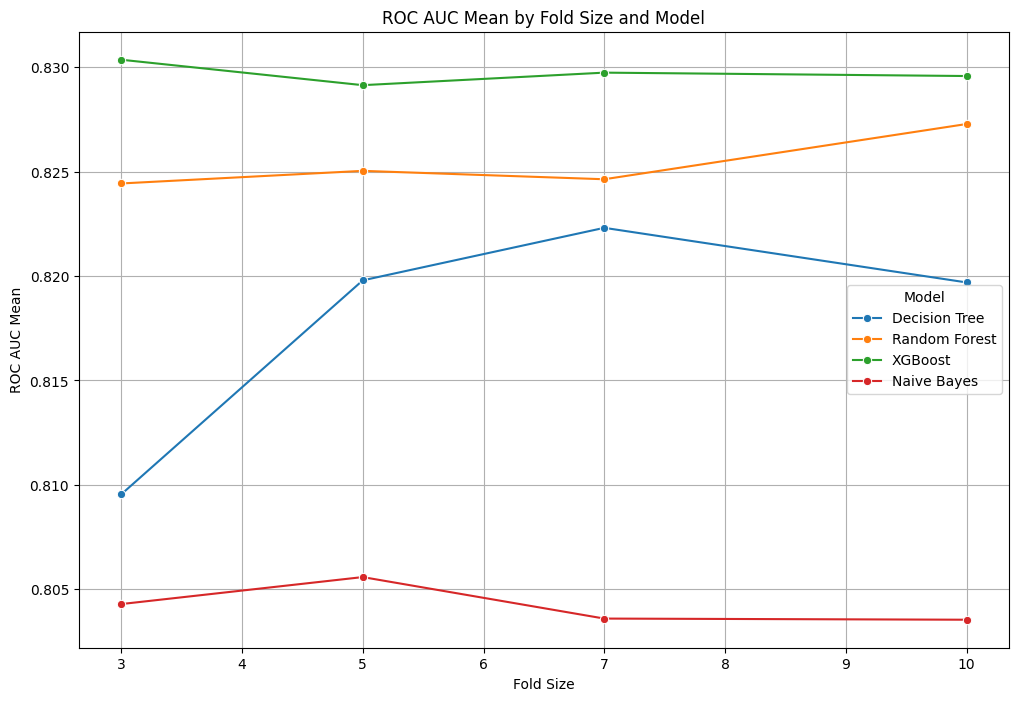

In [17]:
# Differents fold sizes, hyperparameter tuning, model comparison
selected_features = ['Sex_male', 'Embarked_S', 'Fare_bin', 'FamilySize_bin', 'Age_imp_scaled_bin']
target = 'Survived'

X = titanic[selected_features].copy()
y = titanic[target].copy()

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Define fold sizes to test
fold_sizes = [3, 5, 7, 10]

# Parameter grids for Grid Search
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Naive Bayes': GaussianNB()
}

results_all_folds = []

for n_splits in fold_sizes:
    print(f"\nStarting tuning and evaluation with {n_splits}-fold CV...")
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"Tuning {name} with {n_splits}-fold CV...")
        if name != 'Naive Bayes':
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                scoring='roc_auc',
                cv=cv,
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_encoded, y)
            best_model = grid_search.best_estimator_
            print(f"Best params for {name} with {n_splits}-fold: {grid_search.best_params_}")
        else:
            best_model = model
            best_model.fit(X_encoded, y)

        # Evaluate best model with cross-validation on multiple metrics
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        scores = {}
        for metric in metrics:
            score = cross_val_score(best_model, X_encoded, y, cv=cv, scoring=metric, n_jobs=-1)
            scores[metric] = (score.mean(), score.std())

        results_all_folds.append({
            'Model': name,
            'Fold Size': n_splits,
            'Accuracy Mean': scores['accuracy'][0],
            'Accuracy Std': scores['accuracy'][1],
            'Precision Mean': scores['precision'][0],
            'Precision Std': scores['precision'][1],
            'Recall Mean': scores['recall'][0],
            'Recall Std': scores['recall'][1],
            'F1 Mean': scores['f1'][0],
            'F1 Std': scores['f1'][1],
            'ROC AUC Mean': scores['roc_auc'][0],
            'ROC AUC Std': scores['roc_auc'][1]
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results_all_folds)

# Display results
print("\nModel comparison across different fold sizes:")
print(results_df)

# Optional: Plot ROC AUC by fold size for each model
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='Fold Size', y='ROC AUC Mean', hue='Model', marker='o')
plt.title('ROC AUC Mean by Fold Size and Model')
plt.ylabel('ROC AUC Mean')
plt.grid(True)
plt.show()

Hincal Comment:

Key Observations

-XGBoost generally performs best in ROC AUC and precision for fold sizes 3, 5, and 7, with stable metrics and low std.

- At 10 folds, XGBoost’s accuracy and recall drop sharply, while precision spikes unusually high, indicating possible overfitting or instability with this fold size.

- Random Forest and Decision Tree show consistent performance across fold sizes, with slight improvements in accuracy and precision as folds increase.

- Naive Bayes maintains stable recall and F1 scores across folds but generally lower accuracy and ROC AUC compared to tree-based models.

- Variability (std) tends to increase with fold size, especially for smaller datasets or complex models.

Recommendations

- Use 5 or 7 folds for a good balance of stable, reliable estimates and computational efficiency.

- Avoid 10 folds for XGBoost here due to instability in metrics.

- XGBoost remains the top-performing model overall.

- Random Forest is a strong, stable alternative.

- Naive Bayes is useful if recall is prioritized and interpretability is needed

### Precision, Recall, and F1 Score

**Precision**  
Measures the accuracy of positive predictions.  
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

**Recall (Sensitivity)**  
Measures the ability to find all positive instances.  
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

**F1 Score**  
Harmonic mean of precision and recall, balancing both.  
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

**Summary:**

- **Precision:** How many selected items are relevant?  
- **Recall:** How many relevant items are selected?  
- **F1 Score:** Balance between precision and recall.

This study is done by Hincal Topcuoglu. Thank you